# Projekt uczenie maszynowe - regresja

## Biblioteki

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random

Załadowanie danych

In [3]:
df = pd.read_csv("regresja/diamonds.csv")
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Opis i analiza danych przeprowadzone zostaly w projekcie 1

Obróbka danych

In [4]:
df = df.drop_duplicates()
df = df.rename(columns={'x': 'length_in_mm', 'y': 'width_in_mm', 'z': 'depth_in_mm'})
df['cut'] = df['cut'].map({'Ideal': 4, 'Premium': 3, 'Very Good': 2, 'Good': 1, 'Fair': 0})
df['color'] = df['color'].map({'D': 6, 'E': 5, 'F': 4, 'G': 3, 'H': 2, 'I': 1, 'J': 0})
df['clarity'] = df['clarity'].map({'IF': 7, 'VVS1': 6, 'VVS2': 5, 'VS1': 4, 'VS2': 3, 'SI1': 2, 'SI2': 1, 'I1': 0})

Podział na X i y

In [5]:
X = df.drop(columns='price').values
y = df['price'].values.reshape(-1, 1)

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Implementacja regresora drzewa decyzyjnego

In [7]:

class DecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, feature_subset_ratio=1.0):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.feature_subset_ratio = feature_subset_ratio

    def fit(self, X, y):
        self.n_features = X.shape[1]
        self.tree = self._build_tree(np.array(X), np.array(y), depth=0)

    def predict(self, X):
        return np.array([self._predict_input(x, self.tree) for x in X])

    def _mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _best_split(self, X, y):
        best_mse = float('inf')
        best_split = None
        n_features_to_use = max(1, int(self.n_features * self.feature_subset_ratio))
        features = random.sample(range(self.n_features), n_features_to_use)

        for feature_index in features:
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask
                if (len(y[left_mask]) < self.min_samples_split or
                    len(y[right_mask]) < self.min_samples_split or
                    len(y[left_mask]) < self.min_samples_leaf or
                    len(y[right_mask]) < self.min_samples_leaf):
                    continue
                mse = (
                    len(y[left_mask]) * self._mse(y[left_mask]) +
                    len(y[right_mask]) * self._mse(y[right_mask])
                ) / len(y)
                if mse < best_mse:
                    best_mse = mse
                    best_split = {
                        'feature_index': feature_index,
                        'threshold': threshold,
                        'left': (X[left_mask], y[left_mask]),
                        'right': (X[right_mask], y[right_mask])
                    }
        return best_split

    def _build_tree(self, X, y, depth):
        if (self.max_depth is not None and depth >= self.max_depth) or len(X) < self.min_samples_split:
            return {'value': np.mean(y)}
        split = self._best_split(X, y)
        if split is None:
            return {'value': np.mean(y)}
        return {
            'feature_index': split['feature_index'],
            'threshold': split['threshold'],
            'left': self._build_tree(*split['left'], depth + 1),
            'right': self._build_tree(*split['right'], depth + 1)
        }

    def _predict_input(self, x, tree):
        if 'value' in tree:
            return tree['value']
        if x[tree['feature_index']] <= tree['threshold']:
            return self._predict_input(x, tree['left'])
        else:
            return self._predict_input(x, tree['right'])

# Analiza wyników drzewa decyzyjnego


| Parametr            | Znaczenie i sens testowania                                      |
|---------------------|-----------------------------------------------------------------|
| `max_depth`         | Maksymalna głębokość drzewa, kontroluje złożoność modelu.       |
| `min_samples_split` | Min. liczba próbek do podziału węzła, wpływa na rozmiar drzewa.|
| `min_samples_leaf`  | Min. liczba próbek w liściu, pomaga unikać przeuczenia.         |
| `feature_subset_ratio` | Udział cech losowo wybieranych przy podziale, poprawia uogólnienie. |


In [8]:
wyniki_df = pd.read_excel('regresja/wyniki_drzewo_decyzyjne.xlsx')
wyniki_df.head()

,parametr,wartość,zbiór,R2,RMSE,MAE
0,max_depth,2.0,train,0.829881,1651.984394,1036.312175
1,max_depth,2.0,test,0.824692,1659.364699,1045.635657
2,max_depth,4.0,train,0.915754,1162.529838,669.333980
3,max_depth,4.0,test,0.913486,1165.693400,668.325680
4,max_depth,6.0,train,0.954661,852.834822,482.102421


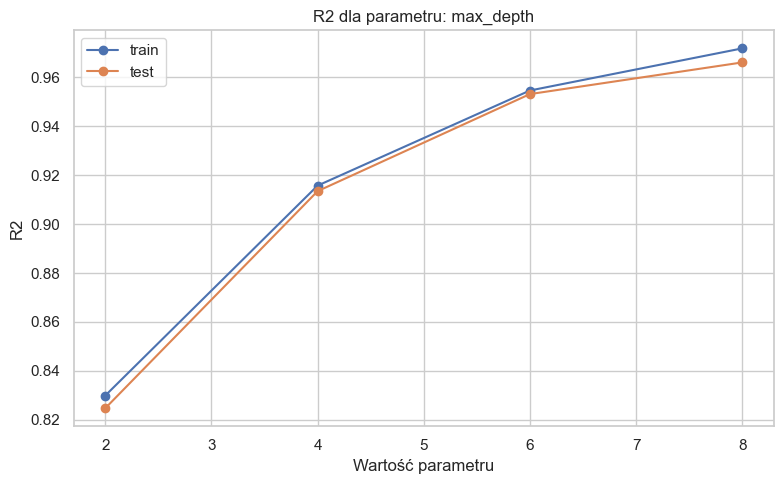

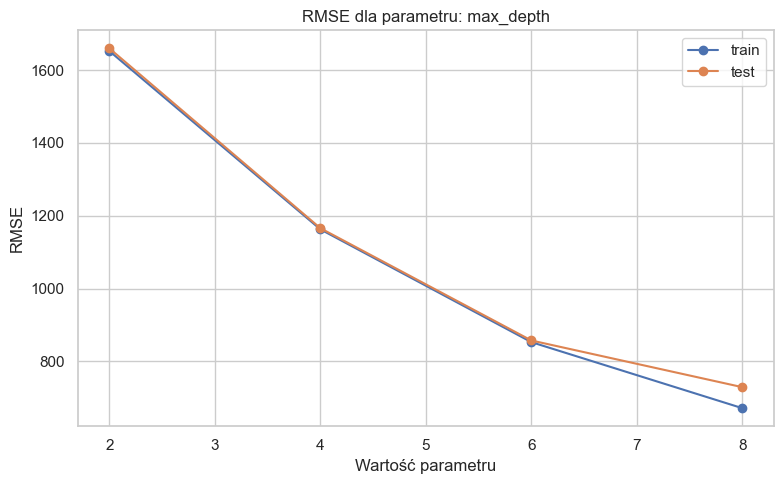

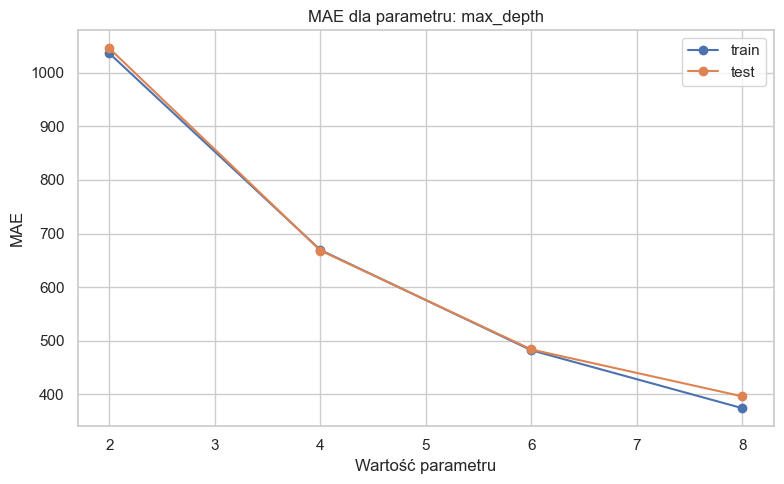

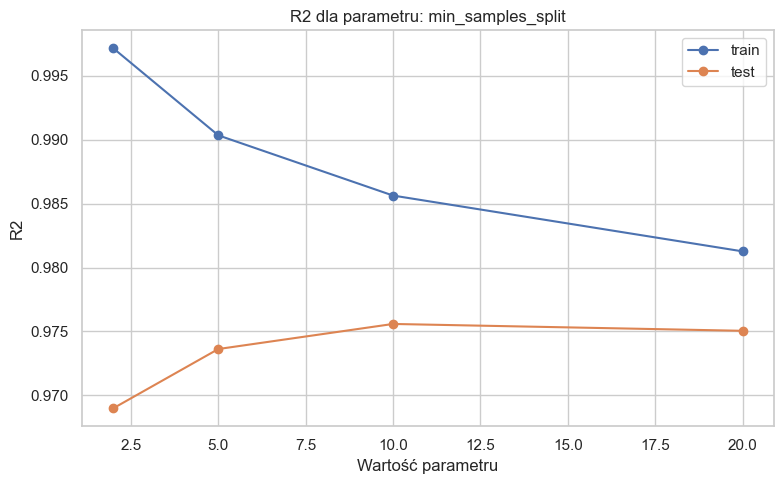

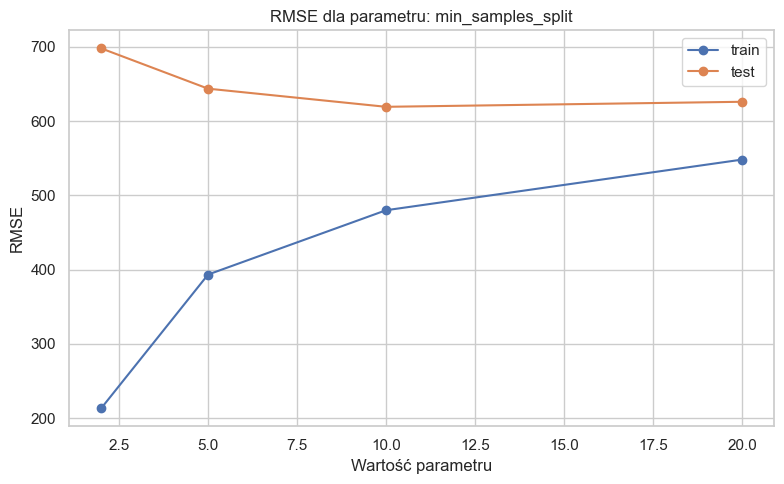

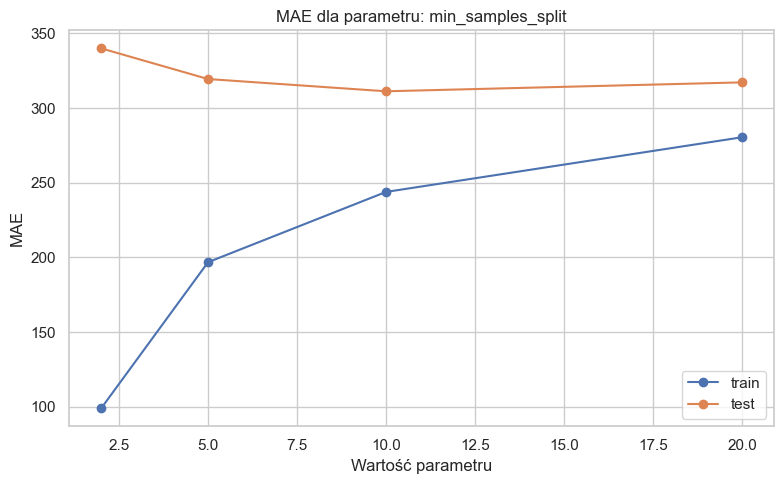

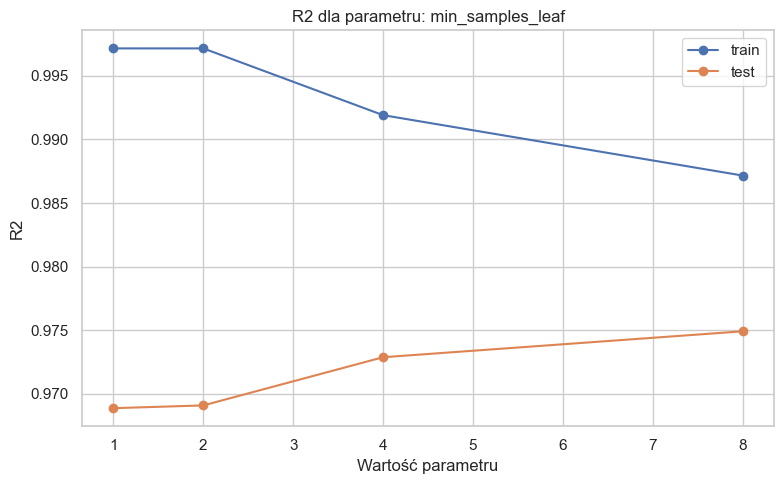

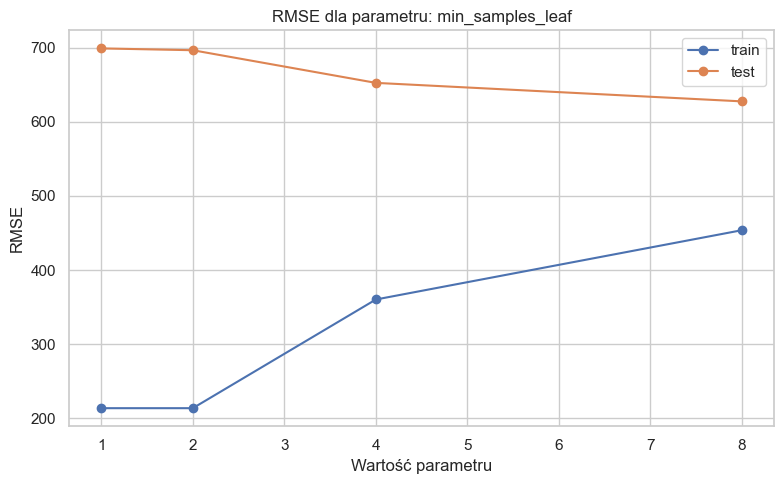

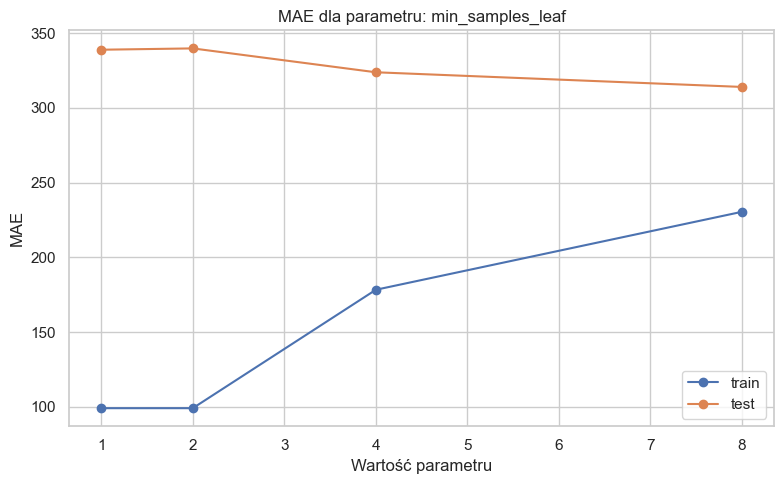

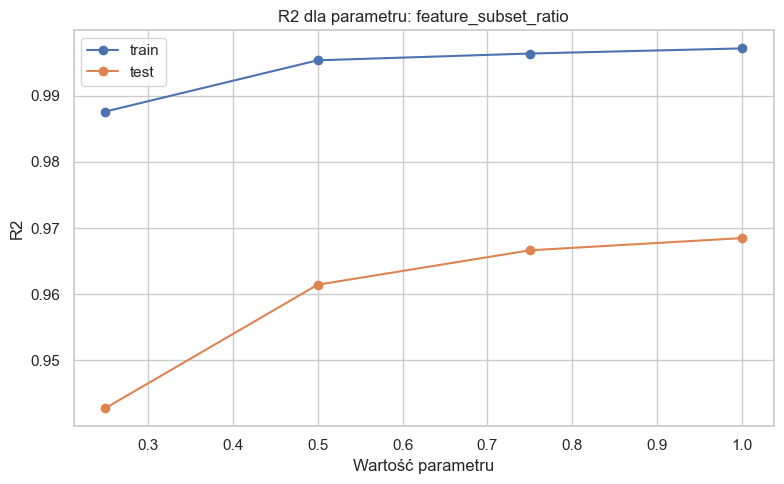

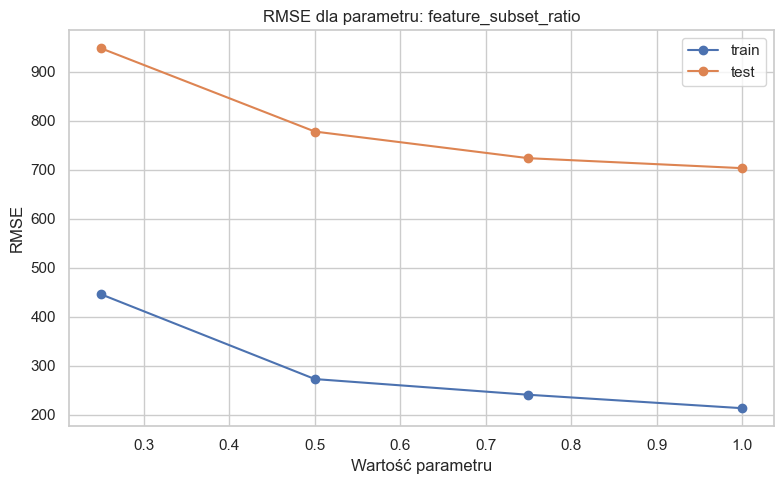

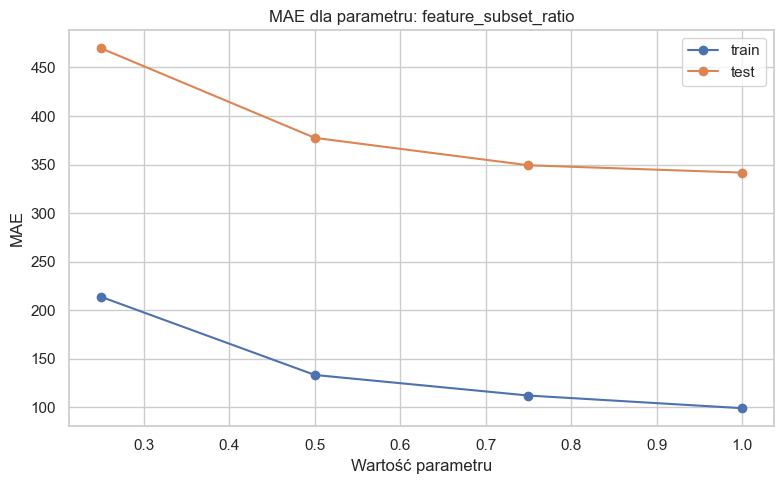

In [9]:
sns.set_theme(style="whitegrid")
metryki = ['R2', 'RMSE', 'MAE']
parametry = wyniki_df['parametr'].unique()

for parametr in parametry:
    dane_param = wyniki_df[wyniki_df['parametr'] == parametr]

    for metryka in metryki:
        plt.figure(figsize=(8, 5))

        for zbior in ['train', 'test']:
            dane_zbior = dane_param[dane_param['zbiór'] == zbior]
            plt.plot(dane_zbior['wartość'], dane_zbior[metryka],
                     marker='o', label=zbior)

        plt.title(f'{metryka} dla parametru: {parametr}')
        plt.xlabel('Wartość parametru')
        plt.ylabel(metryka)
        plt.legend()
        plt.tight_layout()
        plt.show()


##  Najlepsze parametry drzewa decyzyjnego na podstawie zbioru testowego

### Najwyższe **R²** (najlepsze dopasowanie):
| Parametr              | Wartość | R²       |
|------------------------|---------|----------|
| `min_samples_split`    | 10.0    | **0.9756** |
| `min_samples_leaf`     | 8.0     | 0.9749   |
| `feature_subset_ratio` | 1.0     | 0.9685   |
| `max_depth`            | 8.0     | 0.9661   |

---

###  Najniższy **RMSE** (błąd średniokwadratowy):
| Parametr              | Wartość | RMSE     |
|------------------------|---------|----------|
| `min_samples_split`    | 10.0    | **619.2** |
| `min_samples_leaf`     | 8.0     | 627.7    |
| `feature_subset_ratio` | 1.0     | 703.5    |
| `max_depth`            | 8.0     | 729.2    |

---

###  Najniższy **MAE** (średni błąd bezwzględny):
| Parametr              | Wartość | MAE      |
|------------------------|---------|----------|
| `min_samples_split`    | 10.0    | **311.2** |
| `min_samples_leaf`     | 8.0     | 314.0    |
| `feature_subset_ratio` | 1.0     | 341.7    |
| `max_depth`            | 8.0     | 396.0    |


Analiza wykazała, że najlepsze wartości to:
- min_samples_split = 10.0
- min_samples_leaf = 8.0
- feature_subset_ratio = 1.0
- max_depth = 8.0

## Implementacja metody Stochastic Gradient Descent Regression

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

class SGDRegressor:
    def __init__(self, lr=0.01, n_iter=1000, batch_size=32, scaling='standard'):
        self.lr = lr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.scaling = scaling
        self.scaler = None
        self.weights = None
        self.bias = None

    def _scale_features(self, X, fit=False):
        if self.scaling == 'standard':
            if fit or self.scaler is None:
                self.scaler = StandardScaler()
                return self.scaler.fit_transform(X)
            else:
                return self.scaler.transform(X)
        elif self.scaling == 'minmax':
            if fit or self.scaler is None:
                self.scaler = MinMaxScaler()
                return self.scaler.fit_transform(X)
            else:
                return self.scaler.transform(X)
        elif self.scaling == 'robust':
            if fit or self.scaler is None:
                self.scaler = RobustScaler()
                return self.scaler.fit_transform(X)
            else:
                return self.scaler.transform(X)
        elif self.scaling == 'none':
            return X
        else:
            raise ValueError(f"Unknown scaling method: {self.scaling}")

    def fit(self, X, y):
        X = self._scale_features(X, fit=True)
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        for epoch in range(self.n_iter):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, n_samples, self.batch_size):
                end_idx = min(start_idx + self.batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                y_pred = X_batch.dot(self.weights) + self.bias
                error = y_pred - y_batch

                grad_w = (1 / len(y_batch)) * (X_batch.T @ error)
                grad_b = (1 / len(y_batch)) * np.sum(error)

                max_grad = 1e3
                grad_w = np.clip(grad_w, -max_grad, max_grad)
                grad_b = np.clip(grad_b, -max_grad, max_grad)

                self.weights -= self.lr * grad_w
                self.bias -= self.lr * grad_b

                if np.any(np.isnan(self.weights)) or np.any(np.isinf(self.weights)):
                    print("Wagi zawierają NaN lub Inf, zatrzymuję trening.")
                    return

    def predict(self, X):
        X = self._scale_features(X, fit=False)
        return X.dot(self.weights) + self.bias


## Analiza wyników

| Parametr            | Znaczenie i sens testowania                                      |
|---------------------|-----------------------------------------------------------------|
| `lr`         | Współczynnik uczenia – decyduje o wielkości kroku podczas aktualizacji wag.       |
| `n_iter` | Liczba epok, czyli ile razy algorytm „przejrzy” cały zbiór uczący. |
| `batch_size`  | Liczba próbek używanych do jednej aktualizacji wag (mini-batch).         |
| `scaling` | Sposób przeskalowania cech wejściowych. |


In [11]:
wynikisgd_df = pd.read_excel('regresja/wyniki_sgd_regresja.xlsx')
wynikisgd_df.head()

,parametr,wartość,zbiór,R2,RMSE,MAE
0,lr,0.001,train,0.906832,1222.538585,796.176750
1,lr,0.001,test,0.900748,1248.561860,801.076194
2,lr,0.01,train,0.906018,1227.870483,806.477514
3,lr,0.01,test,0.895800,1279.307832,812.538027
4,lr,0.05,train,0.906195,1226.712283,803.812893


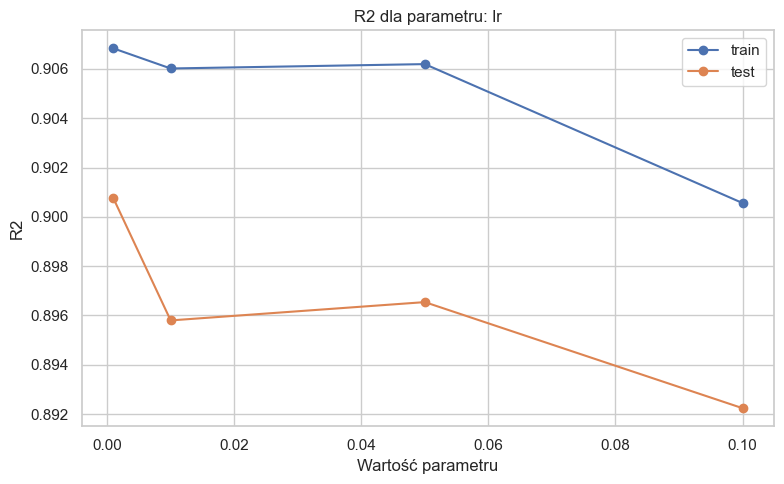

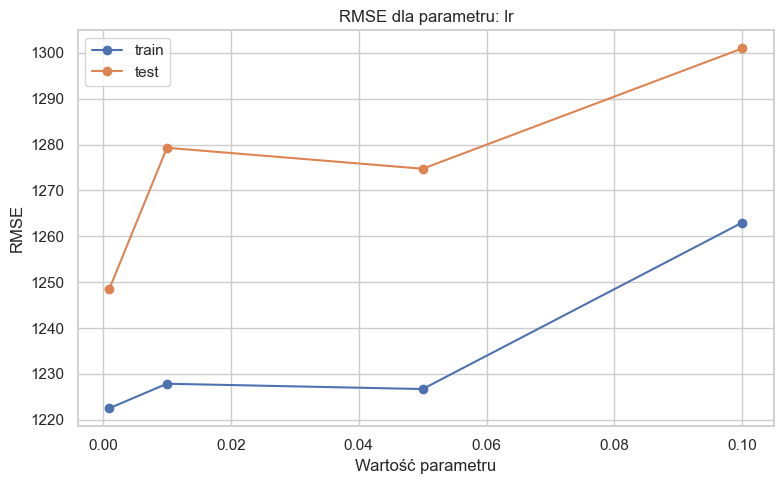

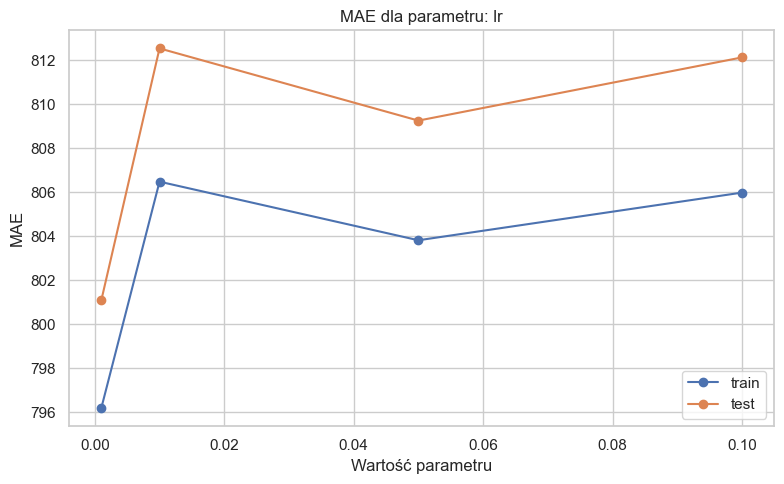

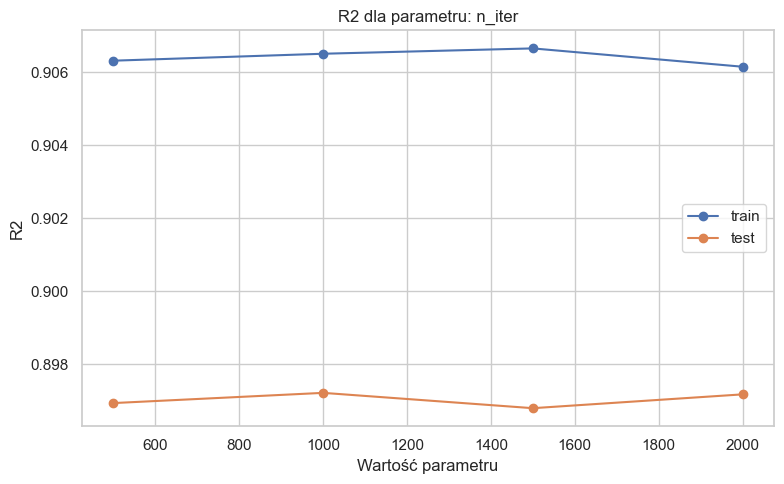

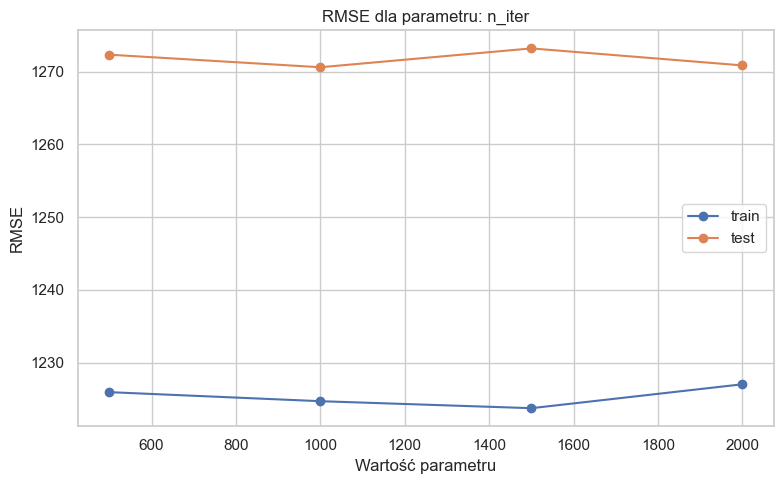

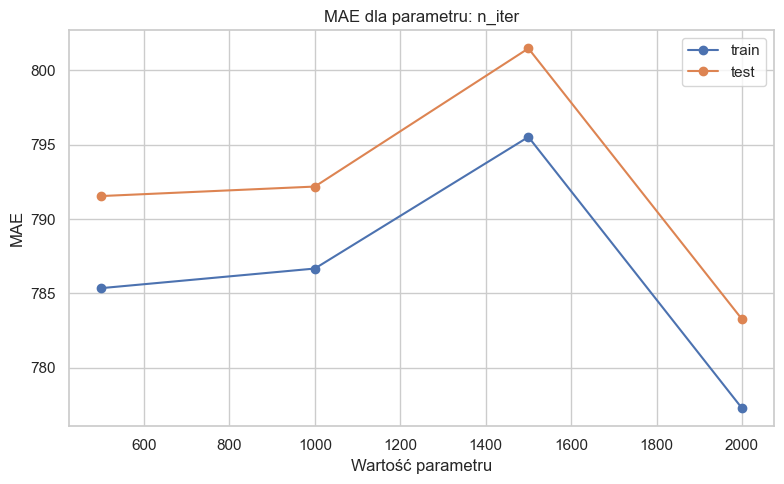

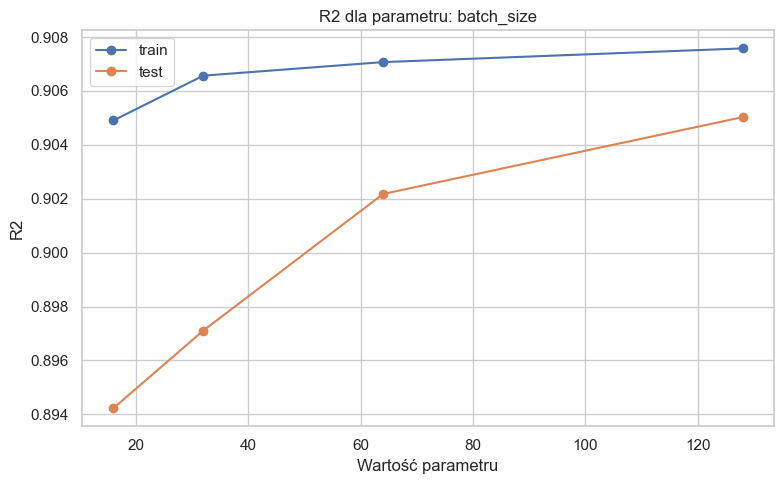

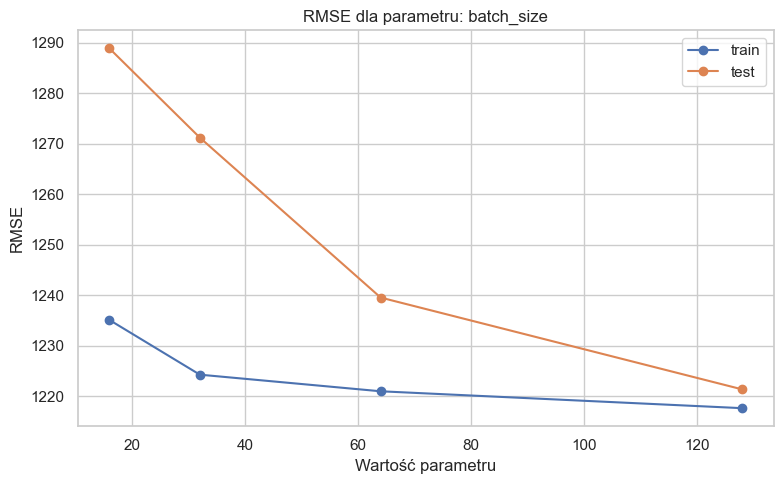

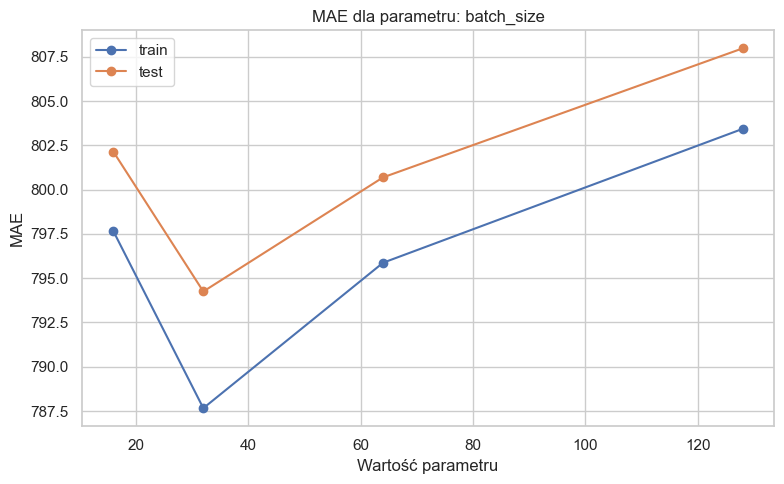

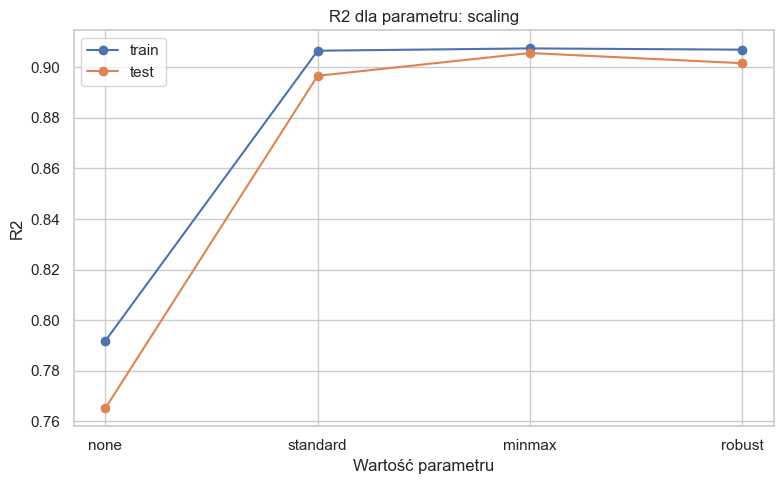

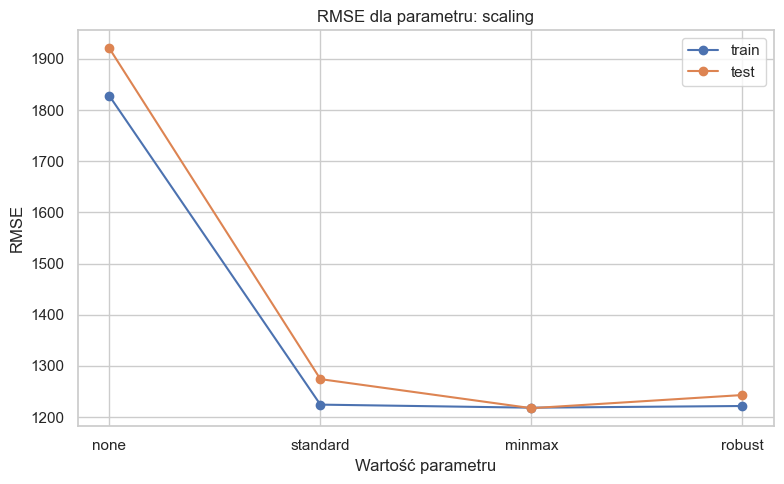

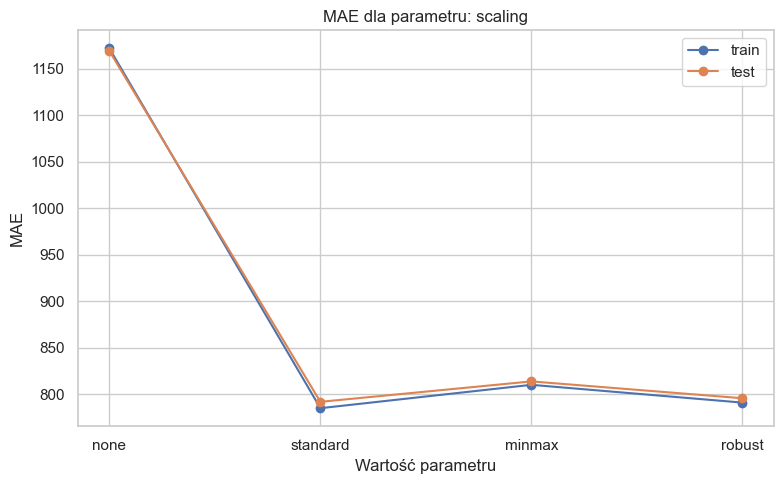

In [12]:
sns.set_theme(style="whitegrid")
metryki = ['R2', 'RMSE', 'MAE']
parametry = wynikisgd_df['parametr'].unique()

for parametr in parametry:
    dane_param = wynikisgd_df[wynikisgd_df['parametr'] == parametr]

    for metryka in metryki:
        plt.figure(figsize=(8, 5))

        for zbior in ['train', 'test']:
            dane_zbior = dane_param[dane_param['zbiór'] == zbior]
            plt.plot(dane_zbior['wartość'], dane_zbior[metryka],
                     marker='o', label=zbior)

        plt.title(f'{metryka} dla parametru: {parametr}')
        plt.xlabel('Wartość parametru')
        plt.ylabel(metryka)
        plt.legend()
        plt.tight_layout()
        plt.show()


##  Najlepsze parametry na podstawie zbioru testowego

### Najwyższe **R²** (najlepsze dopasowanie):
| Parametr              | Wartość | R²       |
|------------------------|---------|----------|
| `lr`    | 0,001    | **0.9007** |
| `n_iter`     | 1000     | 0,8972   |
| `batch_size` | 128     | 0,9050   |
| `scaling`            | minmax     | 0,9056   |

---

###  Najniższy **RMSE** (błąd średniokwadratowy):
| Parametr              | Wartość | RMSE     |
|------------------------|---------|----------|
| `lr`    | 0,001    | **1248,56** |
| `n_iter`     | 1000     | 1270,61    |
| `batch_size` | 128     | 1221,33    |
| `scaling`            | minmax     | 1217,42    |

---

###  Najniższy **MAE** (średni błąd bezwzględny):
| Parametr              | Wartość | MAE      |
|------------------------|---------|----------|
| `lr`    | 0,001    | **801,07** |
| `n_iter`     | 2000     | 783,27    |
| `batch_size` | 32     | 794,24    |
| `scaling`            | standard     | 792,11    |


Analiza wykazała, że najlepsze wartości to:
- lr = 0,001
- n_iter = 1000 lub 2000
- batch_size = 128 lub 32
- scaling = minmax lub standard

# Implementacja KNN


| Parametr        | Znaczenie i sens testowania                                                                 |
|------------------|---------------------------------------------------------------------------------------------|
| `aggregation`    | Określa on, w jaki sposób wartości sąsiadów są agregowane, aby wygenerować wynik.          |
| `p`              | Parametr metryki Minkowskiego – p=1 to metryka Manhattan, p=2 to Euklides, inne wartości pozwalają dostosować przestrzeń metryczną. Testowanie pomaga dobrać optymalną odległość dla danych. |
| `tie_breaker`    | Strategia rozstrzygania remisów (np. losowanie lub preferowanie bliższych sąsiadów). Testowanie pomaga uniknąć niejednoznaczności w przypadku równych głosów. |
| `n_neighbours`   | Określa liczbę sąsiadów branych pod uwagę. Testowanie pomaga dobrać liczbę, która najlepiej dopasowuje się do charakterystyki danych (np. gęstości, rozrzutu). |


In [13]:
class MyKNNRegressor:
    def __init__(self, n_neighbors=5, p=2, weights='uniform', aggregation='mean'):
        self.n_neighbors = n_neighbors
        self.p = p
        self.weights = weights
        self.aggregation = aggregation

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _get_weights(self, distances):
        if self.weights == 'uniform':
            return np.ones_like(distances)
        elif self.weights == 'distance':
            return 1 / (distances + 1e-5)
        elif self.weights == 'custom_linear':
            max_dist = np.max(distances, axis=1, keepdims=True) + 1e-5
            return 1 - distances / max_dist
        elif self.weights == 'custom_inverse':
            return 1 / (distances + 1e-5)
        else:
            return np.ones_like(distances)

    def _weighted_median(self, values, weights):
        result = []
        for val, w in zip(values, weights):
            if np.sum(w) == 0:
                result.append(np.mean(val))
                continue
            sorted_idx = np.argsort(val)
            val_sorted = val[sorted_idx]
            w_sorted = w[sorted_idx]
            cum_weights = np.cumsum(w_sorted)
            cutoff = np.sum(w_sorted) / 2.0
            median_idx = np.searchsorted(cum_weights, cutoff)
            result.append(val_sorted[min(median_idx, len(val_sorted)-1)])
        return np.array(result)

    def predict(self, X):
        if self.p == 1:
            distances = np.sum(np.abs(X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]), axis=2)
        elif self.p == 2:
            distances = np.sqrt(np.sum((X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]) ** 2, axis=2))
        else:
            from scipy.spatial.distance import cdist
            distances = cdist(X, self.X_train, metric='minkowski', p=self.p)

        if np.array_equal(X, self.X_train):
            np.fill_diagonal(distances, np.inf)

        neighbors_idx = np.argpartition(distances, self.n_neighbors, axis=1)[:, :self.n_neighbors]
        row_idx = np.arange(X.shape[0])[:, None]
        selected_distances = distances[row_idx, neighbors_idx]
        neighbors_y = self.y_train[neighbors_idx]
        weights = self._get_weights(selected_distances)

        if self.aggregation == 'mean':
            return np.mean(neighbors_y, axis=1)
        elif self.aggregation == 'median':
            return np.median(neighbors_y, axis=1)
        elif self.aggregation == 'weighted_mean':
            weighted_sum = np.sum(weights * neighbors_y, axis=1)
            weight_sum = np.sum(weights, axis=1)
            return weighted_sum / (weight_sum + 1e-8)
        elif self.aggregation == 'weighted_median':
            return self._weighted_median(neighbors_y, weights)
        else:
            raise ValueError("Nieznana metoda agregacji")

# Analiza wyników KNN

In [14]:
wynikiKNN_df = pd.read_csv('regresja/wyniki_knn_regression.csv')
wynikiKNN_df.head()

,parametr,wartość,zbiór,R2,RMSE,MAE
0,n_neighbors,1,train,0.927891,1061.329126,552.435900
1,n_neighbors,1,test,0.924032,1103.665711,561.780000
2,n_neighbors,3,train,0.949361,889.354870,463.726642
3,n_neighbors,3,test,0.947053,921.344543,477.429067
4,n_neighbors,5,train,0.953751,850.016564,447.005265


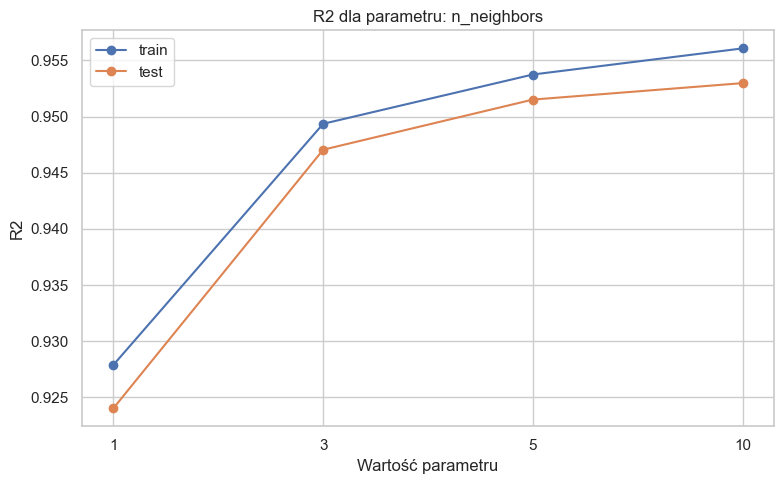

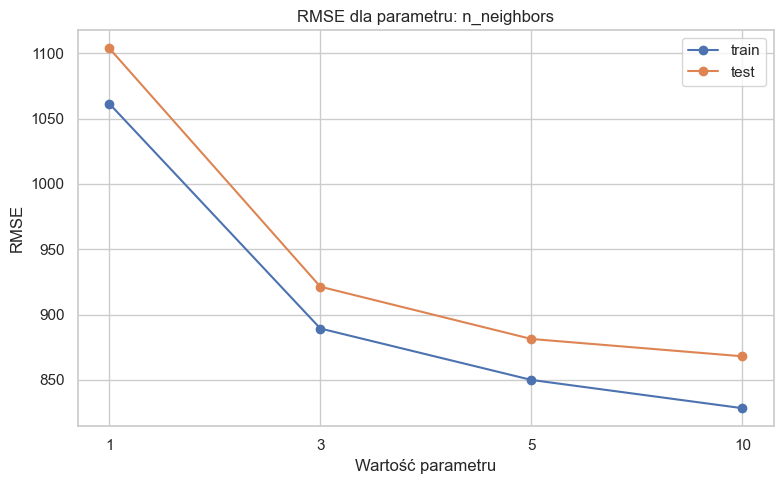

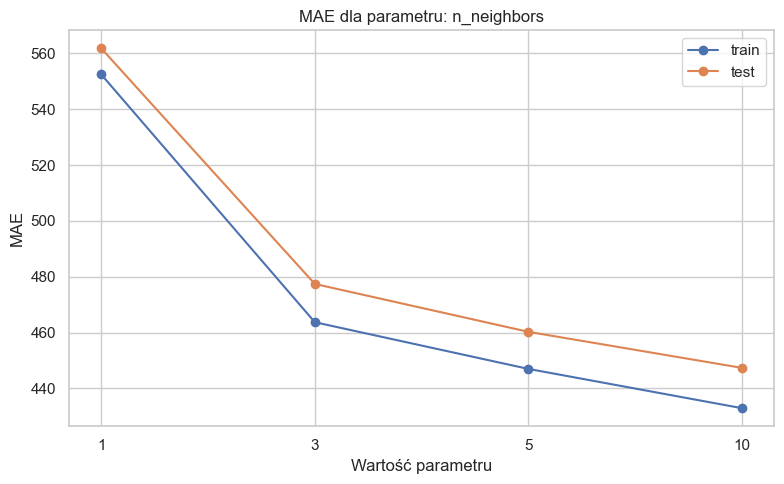

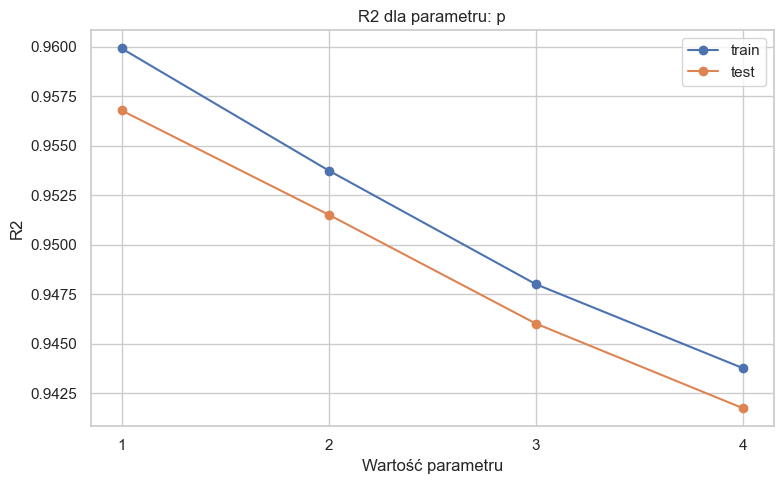

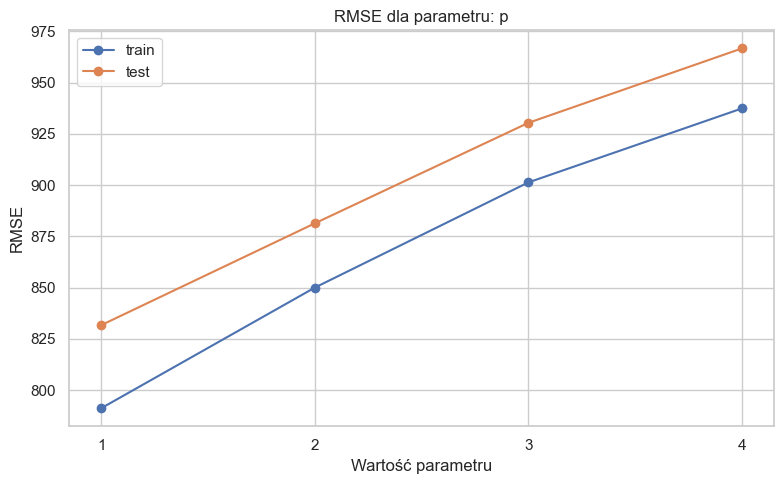

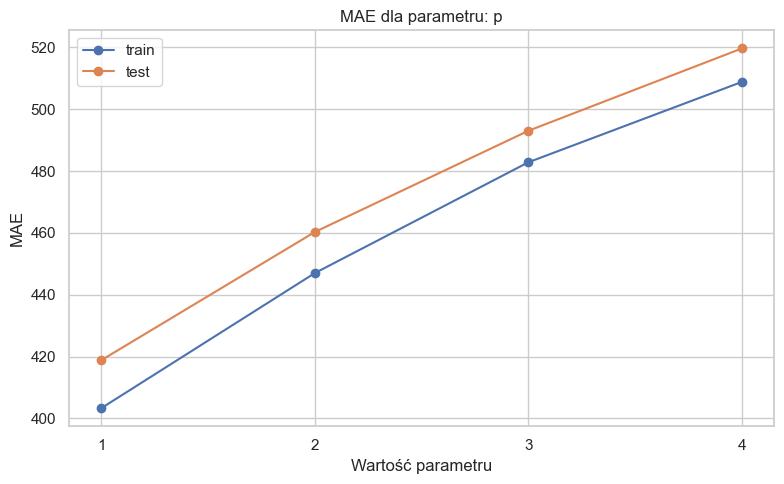

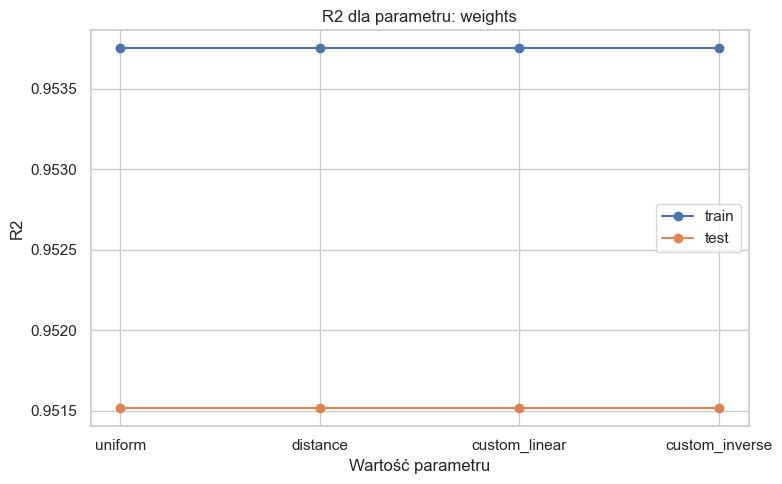

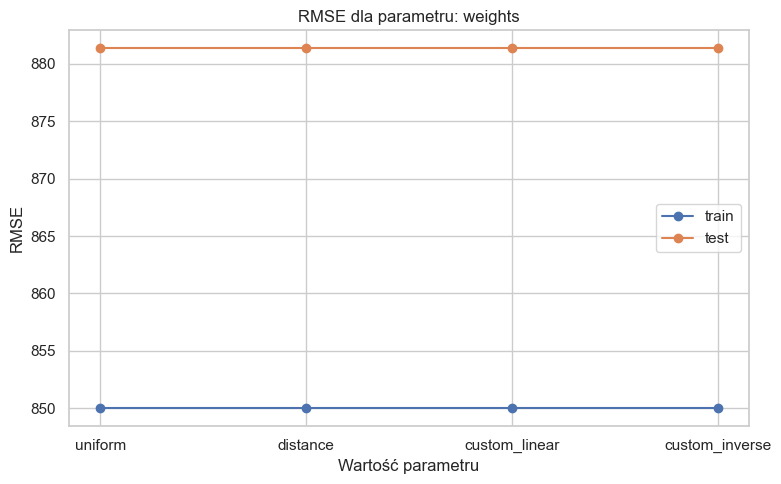

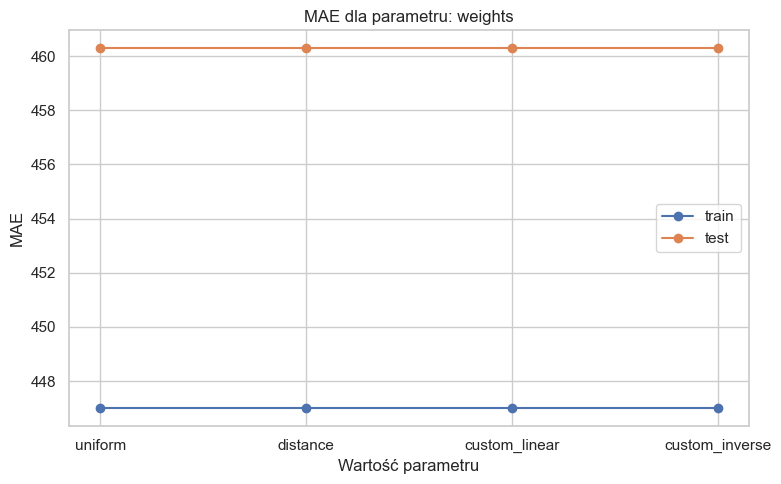

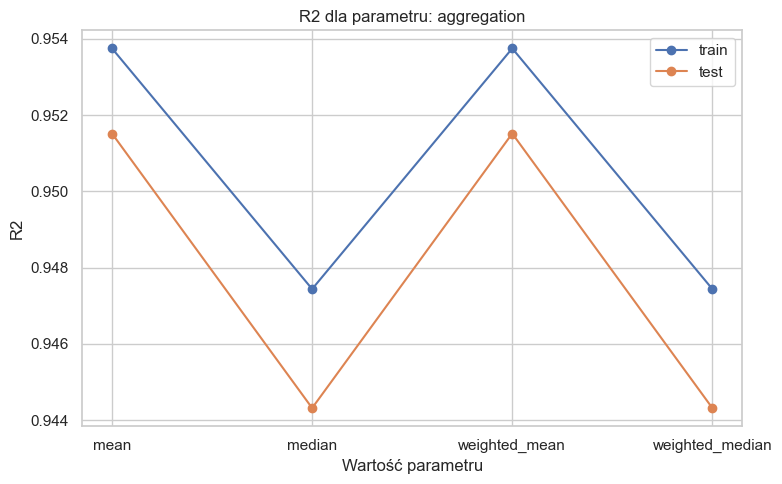

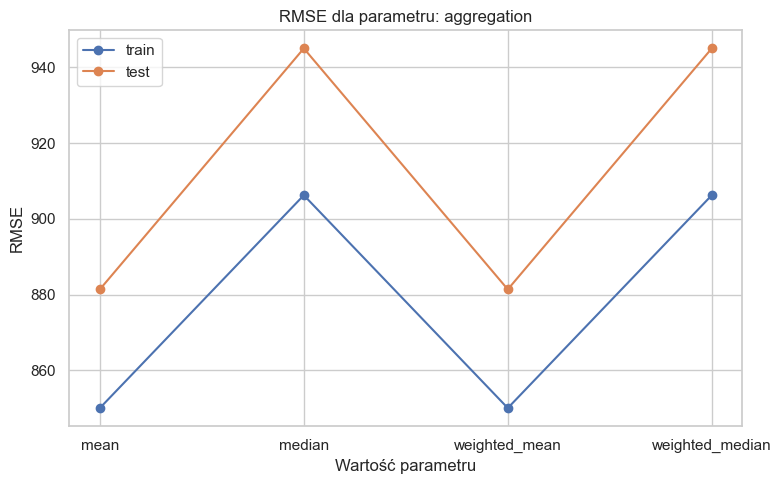

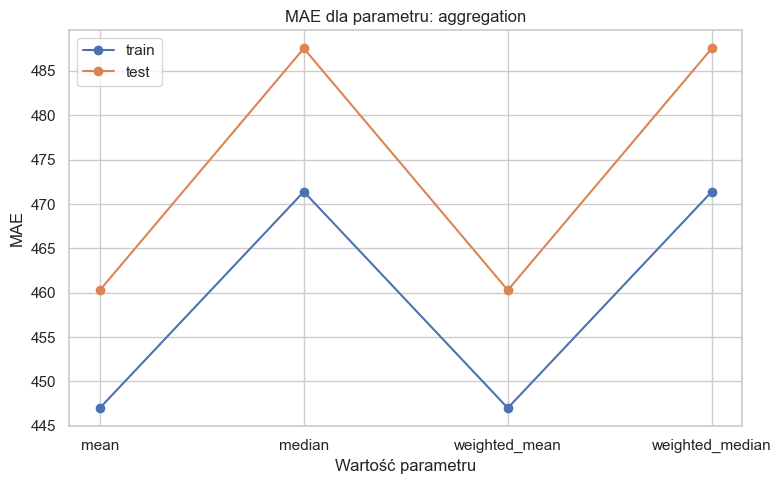

In [15]:
sns.set_theme(style="whitegrid")
metryki = ['R2', 'RMSE', 'MAE']
parametry = wynikiKNN_df['parametr'].unique()

for parametr in parametry:
    dane_param = wynikiKNN_df[wynikiKNN_df['parametr'] == parametr]

    for metryka in metryki:
        plt.figure(figsize=(8, 5))

        for zbior in ['train', 'test']:
            dane_zbior = dane_param[dane_param['zbiór'] == zbior]
            plt.plot(dane_zbior['wartość'], dane_zbior[metryka],
                     marker='o', label=zbior)

        plt.title(f'{metryka} dla parametru: {parametr}')
        plt.xlabel('Wartość parametru')
        plt.ylabel(metryka)
        plt.legend()
        plt.tight_layout()
        plt.show()


##  Najlepsze parametry KNN na podstawie zbioru testowego

### Najwyższe **R²** (najlepsze dopasowanie):
| Parametr              | Wartość | R²       |
|------------------------|---------|----------|
| `n_neighbours`    | 10.0    | 0.953 |
| `p`     | 1.0     | **0.957**   |
| `weights` | dla wszystkich badanych rodzajów     | 0.952   |
| `aggregation`            | mean     | 0.9515   |

---

###  Najniższy **RMSE** (błąd średniokwadratowy):
| Parametr              | Wartość | RMSE     |
|------------------------|---------|----------|
| `n_neighbours`    | 10.0    | 868.1 |
| `p`     | 1.0    | **831.7**   |
| `weights` | dla wszystkich badanych rodzajów     | 850   |
| `aggregation`            | mean     | 881.4   |

---

###  Najniższy **MAE** (średni błąd bezwzględny):
| Parametr              | Wartość | MAE      |
|------------------------|---------|----------|
| `n_neighbours`    | 10.0    | 447.4 |
| `p`     | 1.0     | **418.8**    |
| `weights` | dla wszystkich badanych rodzajów     | 460.3   |
| `aggregation`            | mean     | 460.3   |


Najlepsze parametry dla naszego problemu to:
- n_neighbours = 10
- p = 1
- weights spośród badanych bez znaczenia dla wyników
- aggregation = mean lub weighted-mean

## Podsumowanie projektu regresja

W ramach projektu podjęto się implementacji oraz porównania trzech różnych modeli regresji (drzewo decyzyjne, SGD, KNN) do przewidywania cen diamentów na podstawie ich charakterystyk.

Wykorzystano zbiór danych diamonds.csv, który zawierał szczegółowe informacje o parametrach diamentów takich jak masa (carat), jakość szlifu (cut), kolor (color), czystość (clarity) oraz wymiary fizyczne.

Przed przystąpieniem do trenowania modeli przeprowadzono wstępne przetwarzanie danych poprzez usunięcie duplikatów, zmianę nazw kolumn oraz przekształcenie zmiennych kategorycznych na numeryczne.

Najlepsze wyniki spośród wszystkich modeli osiągnęło drzewo decyzyjne przy parametrach min_samples_split = 10.0, uzyskując imponujący współczynnik determinacji R² = 0.9756 na zbiorze testowym.

W przypadku regresji SGD optymalne rezultaty uzyskano przy learning_rate = 0.001 i batch_size = 128, co pozwoliło osiągnąć R² = 0.9007 na danych testowych.

Model K-najbliższych sąsiadów wykazał najwyższą skuteczność przy zastosowaniu 10 sąsiadów oraz metryki Manhattan (p=1), osiągając R² = 0.957 podczas testowania.

Porównując wszystkie zaimplementowane modele, drzewo decyzyjne okazało się najbardziej efektywne, uzyskując najwyższy współczynnik determinacji oraz najniższe wartości błędów RMSE i MAE.

Warto podkreślić, że wszystkie modele zostały zaimplementowane samodzielnie od podstaw, bez wykorzystania gotowych rozwiązań z biblioteki scikit-learn, co umożliwiło pełną kontrolę nad procesem uczenia i doborem parametrów.